In [1]:
import os
import os.path
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

/Users/victoria/anaconda/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get image feature vectors 

## Method 1: Transform images with the TF Image Feature Vector Module

Introduced at the end of March 2018, Tensorflow Hub is a  library of reusable modules, or parts of machine learning models; more specifically, a self-contained piece of a Tensorflow graph, along with its weights and assets. Common signatures are implemented by modules for the same task so that switching modules is as simple as switching a string-valued hyperparameter. 

For example, this module ("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1") uses the tf-slim inception v3 trained networked, packaged to get feature vectors from images. The image feature vector module produces a dense 1-D tensor that discards the classification learned by publisher model. Feature vectors AKA bottleneck values are the layer just before the final output layer in the neural network, meaning this small set of values must contain a summary of the images with enough information for the classifier to make a good choice.

For this module, the size of the input image is fixed to height x width = 299 x 299 pixels. The input images are expected to have color values in the range [0,1], following the common image input conventions. The common image input signature accepts a batch of images as dense 4-D tensor of dtype float32 and shape [batch_size, height, width, 3]. This is what you get from tf.images.decode followed by tf.image.convert_image_dtype(..., tf.float32).

More details on how to use this module are here: https://www.tensorflow.org/hub/common_signatures/images#feature-vector

## Method 2: Read TFRecords with the TF Data API

Because we've already trained a model and saved the data as TFRecords, we can read those back in to get the image feature vectors rather than recreate them from images. 

The TFRecord file format is a record-oriented binary format. TensorFlow defines two protocol buffer message types for use with TFRecords: the Example message type and the SequenceExample message type. An Example contains a key-value store (features); where each key (string) maps to a Feature message (which is one of packed BytesList, FloatList, or Int64List). 

We can extract Example protocol buffer messages from the TFRecord. Each Example contains one or more features and the input pipeline will convert these features into tensors. We can examine an Example to understand the features.

In [2]:
my_example = tf.train.Example(features=tf.train.Features(feature={
    'my_ints': tf.train.Feature(int64_list=tf.train.Int64List(value=[5, 6])),
    'my_float': tf.train.Feature(float_list=tf.train.FloatList(value=[2.7])),
    'my_bytes': tf.train.Feature(bytes_list=tf.train.BytesList(value=['data']))
}))

In [3]:
reader = tf.python_io.tf_record_iterator('/Users/victoria/honey-data-science/product_tagging/preproc/deepstyle/wc/v2/test-00000-of-00043.tfrecord')
those_examples = [tf.train.Example().FromString(example_str)
                  for example_str in reader]

In [4]:
my_example = those_examples[0]

In [5]:
#my_example

The values in the Example can be accessed like this.

In [6]:
my_example.features.feature['image_uri'].bytes_list.value

['gs://honey-data-science/product_tagging/images/wc_business_v2/1B074RCTQSC.jpg']

In [7]:
my_example.features.feature['label'].int64_list.value

[0L]

In [8]:
my_example.features.feature['embedding'].float_list.value[:5]

[0.06211639195680618,
 0.3119525611400604,
 0.4375796318054199,
 0.33791661262512207,
 0.2100047469139099]

### Step 1: Make a Dataset

The QueueRunner and Feeding methods of inputting data are no longer recommended, instead the preferred method is to use the tf.data API. The tf.data API has two abstractions: Dataset and Iterator. 

The recommended way to read a TFRecord file is with a TFRecordDataset. The TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline. 

A Dataset represents a sequence of elements, in which each element contains one or more Tensor objects, called components. The Dataset.output_types and Dataset.output_shapes properties allow you to inspect the inferred types and shapes of each component. Tensors are generalizations of vectors and matrices to higher dimensions, represented internally as n-dimensional arrays of base datatypes. A Tensor object represents a partially defined computation that will eventually produce a value.

For example, in an image pipeline, an element might be a single training example, with a pair of tensors representing the image data and a label. 

In [9]:
mypath = "/Users/victoria/honey-data-science/product_tagging/preproc/deepstyle/wc/v2"
filenames = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
dataset = tf.data.TFRecordDataset(filenames)

### Step 2: Transform a Dataset

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on it. For example, you can apply per-element transformations such as Dataset.map() to apply a function to each element. 

In [10]:
# Define features
read_features = {
    'embedding': tf.VarLenFeature(dtype=tf.float32),
    'image_uri': tf.VarLenFeature(dtype=tf.string),
    'label': tf.VarLenFeature(dtype=tf.int64)}

In [11]:
def parser(serialized_example):
    parsed = tf.parse_single_example(serialized=serialized_example,
                                    features=read_features)
    return parsed["label"], parsed["embedding"], parsed["image_uri"]

In [12]:
dataset = dataset.map(parser)

### Step 3: Iterate over the Dataset

The most common way to consume values from a Dataset is to make an iterator object that provides access to one element of the dataset at a time. The Iterator.get_next() method returns one or more Tensor objects that correspond to the symbolic next element of an iterator.

In [13]:
iterator = dataset.make_initializable_iterator()

In [14]:
next_element = iterator.get_next()

### Step 4: Run the TF session

Calling Iterator.get_next() does not immediately advance the iterator. Instead you must use the returned Tensor objects in a TensorFlow expression, and pass the result of that expression to tf.Session.run() to get the next elements and advance the iterator.

TensorFlow represents a sparse tensor as three separate dense tensors: indices, values, and dense_shape. In Python, the three tensors are collected into a SparseTensor class for ease of use. Tensors can be accessed as arrays with .eval(), then the values can then be accessed.

In [15]:
embeddings = []
labels = []
uris = []
sess = tf.Session()

# A common pattern is to wrap the "training loop" in a try-except block:
sess.run(iterator.initializer)
while True:
    try:
        labels.extend(next_element[0].eval(session=sess).values)
    except tf.errors.OutOfRangeError:
        break
print(len(labels))

sess.run(iterator.initializer)
while True:
    try:
        embeddings.append(next_element[1].eval(session=sess).values)
    except tf.errors.OutOfRangeError:
        break
embeddings = np.array(embeddings)
print(len(embeddings))

sess.run(iterator.initializer)
while True:
    try:
        uris.extend(next_element[2].eval(session=sess).values)
    except tf.errors.OutOfRangeError:
        break
print(len(uris))

971
971
971


# Configure Tensorboard Projector

## Method 1: With labels only

### Save labels

The labels are written to a tab-separated metadata csv file. 

In [16]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = 'image_projector_test'
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

Instructions for updating:
Use the retry module or similar alternatives.


In [17]:
with open(metadata, 'w') as metadata_file:
    for i in labels:
        metadata_file.write('%s\n' % i)

### Save embeddings

The image embeddings are stored as a Tensorflow variable. A TensorFlow variable is the best way to represent a shared, persistent state manipulated by your program. A Variable represents a tensor whose value can be changed by running ops on it. 

Unlike Tensor objects, a Variable exists outside the context of a single session.run call.
Variables have to be explicitly initialized before you can run Ops that use their value. You can initialize a variable by running its initializer op, restoring the variable from a save file, or simply running an assign Op that assigns a value to the variable. The image variables are initialized and stored in images.ckpt

In [18]:
images = tf.Variable(embeddings, name='images')

with tf.Session() as sess:
    saver = tf.train.Saver([images])
    
    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))

### Add the embeddings and metadata to the projector config

Then the projector config is linked to the image embeddings and their metadata.

In [19]:
with tf.Session() as sess:
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = 'metadata.tsv'
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

`tensorboard --logdir=image_projector`

## Method 2: With labels and images

The max image sprite size supported by Tensorboard is 8192 x 8192, but the image projector will not load at this size. A much smaller size, like 2400 × 2400, loads quickly.

### Get a list of images

In [20]:
img_list = [i.replace('gs://', '/Users/victoria/') for i in uris]

In [21]:
img_data=[]
for img in img_list:
    input_img = cv2.imread(img)
    if input_img is not None:
            img = cv2.resize(input_img, (75,75))
            img_data.append(img)
    else:
        print("image not loaded")

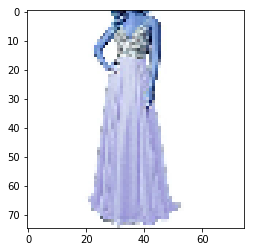

In [22]:
plt.imshow(img_data[900])

In [23]:
img_data = np.array(img_data)

In [24]:
img_data.shape

(971, 75, 75, 3)

### Make sprite

In [25]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

sprite = images_to_sprite(img_data)

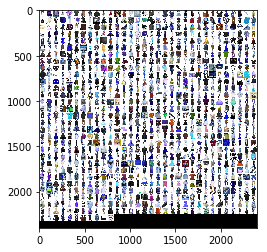

In [26]:
plt.imshow(sprite)

### Save labels

In [27]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = 'image_projector_sprite'
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

In [28]:
with open(metadata, 'w') as metadata_file:
    for i in labels:
        metadata_file.write('%s\n' % i)

### Save embeddings

In [29]:
images = tf.Variable(embeddings, name='images')

with tf.Session() as sess:
    saver = tf.train.Saver([images])
    
    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))

### Save sprite

In [30]:
cv2.imwrite(os.path.join(LOG_DIR, 'sprite.png'), sprite)

True

### Add the embeddings and metadata to the projector config

In [31]:
with tf.Session() as sess:
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    # embedding.metadata_path = metadata
    embedding.metadata_path = 'metadata.tsv'
    
    # Specify the image sprite location (created below)
    embedding.sprite.image_path = 'sprite.png'
    embedding.sprite.single_image_dim.extend([75,75])

    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

`tensorboard --logdir=image_projector_sprite`